# Robust nucleation control via crisscross polymerization of highly coordinated DNA slats

Dionis Minev, Christopher M. Wintersinger, Anastasia Ershova, William M. Shih

## Stochastic model simulations for reproducing results used in figure 3F and S32

v6.2 at experimental conditions of 50°C, 14 mM MgCl2, and 1.5 µM each slat, considering only seed-initiated assembly

### Import dependencies and data

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import sem
from scipy.stats import ks_2samp
from scipy.optimize import minimize

In [2]:
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['lines.linewidth'] = 5
plt.rcParams['lines.markersize'] = 9
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['figure.figsize'] = [10,8]
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['legend.title_fontsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['figure.titleweight'] = 'bold'
sns.set_palette('colorblind')

In [3]:
filename = 'TEM_measurements_v6_2_50C_14mM_MgCl2_1_5uM_slat'
df = pd.read_csv(f'./data/{filename}.csv')

In [4]:
t = [15,30,60,1200]

### Fit model to data

In [5]:
random_seed = 42
seed_num = 150

In [6]:
mean_lengths = [df.mean()[i]/1000 for i in range(len(t))] # in micrometres
sem_lengths = [df.sem()[i]/1000 for i in range(len(t))] # in micrometres
filament_counts = [len(df.iloc[:,i].dropna()) for i in range(len(t))]

In [7]:
p_term_init = 0.002
growth_rate_init = 15
p_stall_init = 0.05

In [8]:
def run_fitting(variables):
    
    timesteps = t[:] # use all data for fitting
    
    # scipy.optimize.minimize uses a step size of 5% - too small for our purposes
    # therefore here I convert a 5% change into a 50% change
    
    p_term,growth_rate,p_stall = variables
    
    p_term = p_term_init-20*(p_term_init-p_term)
    growth_rate = growth_rate_init-20*(growth_rate_init-growth_rate)
    p_stall = p_stall_init-20*(p_stall_init-p_stall)
    
    # avoid negative values due to conversion above
    if p_term < 0: p_term = 0
    if growth_rate < 0: growth_rate = 0
    if p_stall < 0: p_stall = 0
    
    print(p_term,growth_rate,p_stall)
    
    total_filaments = []
    
    for i,step in enumerate(t): # run simulation for all incubation times
            
        if i == 0: # initialise simulation for first timestep
            np.random.seed(random_seed)
            term_filaments = np.array([])
            growing_filaments = np.full(seed_num,0)
            stall_filaments = np.array([])

            prev_step = 0
        
        # perform reaction for length of incubation

        for ts in np.arange(prev_step,step):
            
            recover_inds = []
            for j,filament in enumerate(stall_filaments):
                if np.random.choice([0,1],p=[p_stall,1-p_stall]) == 0: # recover growth of some stalled filaments
                    recover_inds.append(j)
                    growing_filaments = np.append(growing_filaments,stall_filaments[j])
            stall_filaments = np.delete(stall_filaments,recover_inds)

            # grow all filaments
            growing_filaments = growing_filaments + np.full(len(growing_filaments),growth_rate)
            
            term_inds = []
            for j,filament in enumerate(growing_filaments):
                if np.random.choice([0,1],p=[p_term,1-p_term]) == 0: # terminate growth of filaments
                    term_inds.append(j)
                    term_filaments = np.append(term_filaments,growing_filaments[j])
            growing_filaments = np.delete(growing_filaments,term_inds)
            
            term_inds = []
            for j,filament in enumerate(stall_filaments):
                if np.random.choice([0,1],p=[p_term,1-p_term]) == 0: # terminate growth of stalled filaments
                    term_inds.append(j)
                    term_filaments = np.append(term_filaments,stall_filaments[j])
            stall_filaments = np.delete(stall_filaments,term_inds)
            
            stall_inds = []
            for j,filament in enumerate(growing_filaments):
                if np.random.choice([0,1],p=[p_stall,1-p_stall]) == 0: # pause growth of filaments
                    stall_inds.append(j)
                    stall_filaments = np.append(stall_filaments,growing_filaments[j])
            growing_filaments = np.delete(growing_filaments,stall_inds)

        total_filaments.append(np.concatenate((growing_filaments,term_filaments,stall_filaments),axis=None))
        
        prev_step = step

    ks = []

    for i,step in enumerate(timesteps):

        data = df.iloc[:,i].dropna()
        model = total_filaments[i]
        ks.append(ks_2samp(model,data)[0])

    return np.mean(ks)

In [9]:
minim_results = minimize(run_fitting,(p_term_init,growth_rate_init,p_stall_init),
                         method='Nelder-Mead',options={'fatol':0.001})

0.002 15.0 0.05
0.004000000000000005 15.0 0.05
0.002 30.0 0.05
0.002 15.0 0.10000000000000005
0 25.0 0.08333333333333355
0.0006666666666666574 31.666666666666643 0.022222222222222046
0 42.777777777777715 0.05370370370370382
0.0014444444444444392 21.94444444444443 0.05092592592592589
0.001629629629629632 19.62962962962962 0.10061728395061777
0.0033827160493827193 22.716049382716008 0.05102880658436222
0.0029218106995884795 30.14403292181072 0.0006858710562406972
0.0019526748971193438 22.258230452674894 0.07563443072702343
0.0025987654320987676 27.515432098765444 0.025668724279835034
0.0038765432098765464 31.54320987654323 0.03353909465020562
0.0022674897119341567 36.65637860082306 0.02177640603566479
0.0031039094650205743 26.20113168724277 0.04371570644718793
0.0012585733882030208 24.2678326474622 0.046050525834476455
0.0016428898033836233 26.130544124371156 0.06750876390794104
0.0032392927907331052 30.61995122694711 0.061432454402276473
0.004229652491998139 33.79601051668956 0.06912341

In [10]:
# extract parameters from minimisation and rescale

p_term,growth_rate,p_stall = minim_results.x
p_term = p_term_init-20*(p_term_init-p_term)
growth_rate = growth_rate_init-20*(growth_rate_init-growth_rate)
p_stall = p_stall_init-20*(p_stall_init-p_stall)

### Run model for in-between timesteps

In [11]:
def run_model(t,p_term,growth_rate,p_stall,tem=True):
    
    total_filaments = []
    
    for i,step in enumerate(t): # run simulation for all incubation times
            
        if i == 0: # initialise simulation for first timestep
            np.random.seed(random_seed)
            term_filaments = np.array([])
            growing_filaments = np.full(seed_num,0)
            stall_filaments = np.array([])

            prev_step = 0
        
        # perform reaction for length of incubation

        for ts in np.arange(prev_step,step):
            
            recover_inds = []
            for j,filament in enumerate(stall_filaments):
                if np.random.choice([0,1],p=[p_stall,1-p_stall]) == 0: # recover growth of some stalled filaments
                    recover_inds.append(j)
                    growing_filaments = np.append(growing_filaments,stall_filaments[j])
            stall_filaments = np.delete(stall_filaments,recover_inds)

            # grow all filaments
            growing_filaments = growing_filaments + np.full(len(growing_filaments),growth_rate)
            
            term_inds = []
            for j,filament in enumerate(growing_filaments):
                if np.random.choice([0,1],p=[p_term,1-p_term]) == 0: # terminate growth of filaments
                    term_inds.append(j)
                    term_filaments = np.append(term_filaments,growing_filaments[j])
            growing_filaments = np.delete(growing_filaments,term_inds)
            
            term_inds = []
            for j,filament in enumerate(stall_filaments):
                if np.random.choice([0,1],p=[p_term,1-p_term]) == 0: # terminate growth of stalled filaments
                    term_inds.append(j)
                    term_filaments = np.append(term_filaments,stall_filaments[j])
            stall_filaments = np.delete(stall_filaments,term_inds)
            
            stall_inds = []
            for j,filament in enumerate(growing_filaments):
                if np.random.choice([0,1],p=[p_stall,1-p_stall]) == 0: # pause growth of filaments
                    stall_inds.append(j)
                    stall_filaments = np.append(stall_filaments,growing_filaments[j])
            growing_filaments = np.delete(growing_filaments,stall_inds)

        total_filaments.append(np.concatenate((growing_filaments,term_filaments,stall_filaments),axis=None))
        
        prev_step = step
        
    if tem == True:

        ks = []

        for i,step in enumerate(t):

            data = df.iloc[:,i].dropna()
            model = total_filaments[i]
            ks.append(ks_2samp(model,data))

        return total_filaments,ks
    
    else:
        
        return total_filaments

In [12]:
filaments,ks = run_model(t,p_term,growth_rate,p_stall)

### Evaulate fit by comparing CDFs via KS statistic

In [13]:
ks

[Ks_2sampResult(statistic=0.12050314465408805, pvalue=0.19078473115417593),
 Ks_2sampResult(statistic=0.07185840707964601, pvalue=0.8617683744012238),
 Ks_2sampResult(statistic=0.13467625899280575, pvalue=0.12931977900786473),
 Ks_2sampResult(statistic=0.09688564476885644, pvalue=0.47298185141385773)]

Text(0.5, 0.98, 'TEM_measurements_v6_2_50C_14mM_MgCl2_1_5uM_slat')

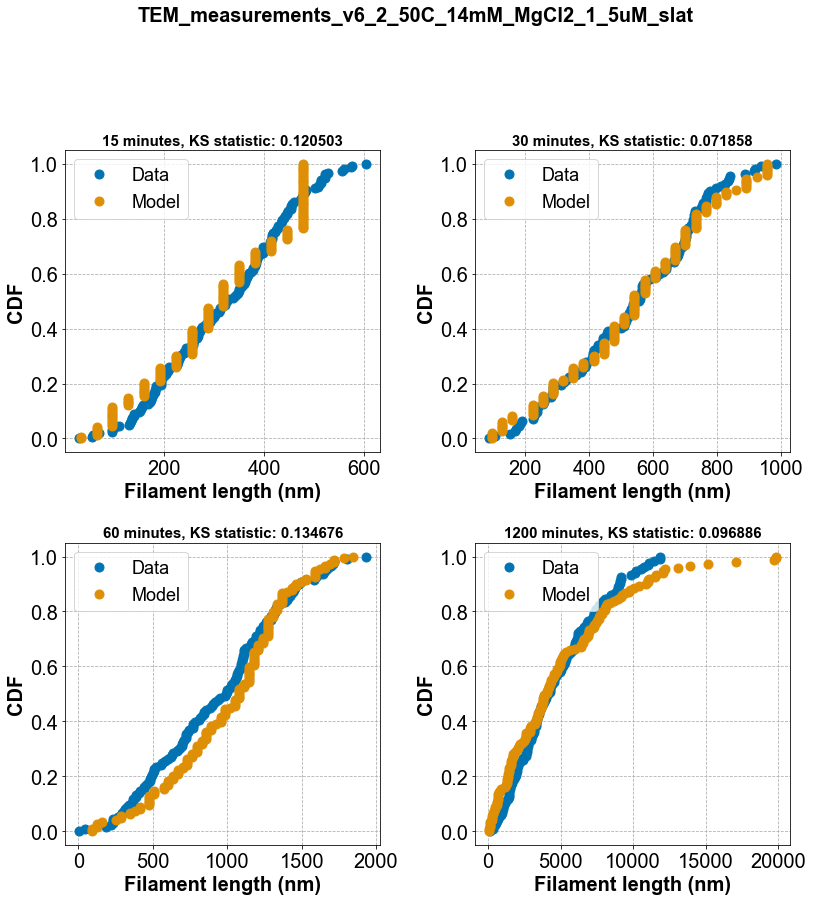

In [14]:
plt.figure(figsize=[13,20])

for i,step in enumerate(t):
    plt.subplot(f'32{i+1}')
    data = df.iloc[:,i].dropna()
    model = filaments[i]
    cdf_data = 1. * np.arange(len(data))/(len(data)-1)
    cdf_model = 1. * np.arange(len(model))/(len(model)-1)
    plt.plot(np.sort(data),cdf_data,'o',label='Data')
    plt.plot(np.sort(model),cdf_model,'o',label='Model')
    plt.ylabel('CDF')
    plt.xlabel('Filament length (nm)')
    plt.title(f'{step} minutes, KS statistic: {np.round(ks[i][0],6)}',fontsize=15)
    plt.legend(loc=2)
    
plt.subplots_adjust(hspace=0.3,wspace=0.3)
plt.suptitle(filename)

In [15]:
extended_times = np.linspace(0,2000,251)
extended_filaments = run_model(extended_times,p_term,growth_rate,p_stall,tem=False)

In [16]:
p_term

0.0030920139563176147

In [17]:
growth_rate

31.842456004419475

In [18]:
p_stall

0.11647559978884832

### Generate plots for figure S32

In [19]:
bins = [np.linspace(0,max(df.iloc[:,-1])/1000,60),np.linspace(0,max(df.iloc[:,-1])/1000,60),
       np.linspace(0,max(df.iloc[:,-1])/1000,60),np.linspace(0,max(df.iloc[:,-1])/1000,10)]

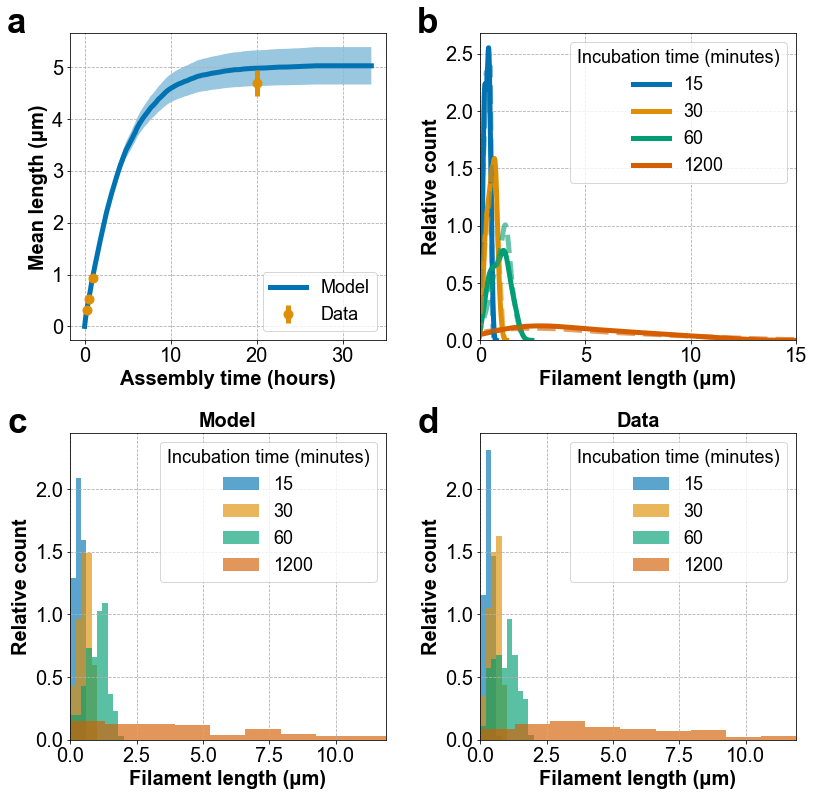

In [20]:
plt.figure(figsize=[13,13])

plt.subplot(221)

model_means = [np.mean(extended_filaments[i])/1000 for i in range(len(extended_times))]
model_sems = [sem(extended_filaments[i])/1000 for i in range(len(extended_times))]
plt.plot(extended_times/60,model_means,'-',label='Model')
plt.fill_between(extended_times/60,np.asarray(model_means)-np.asarray(model_sems),
                 np.array(model_means)+np.array(model_sems),alpha=0.4)
plt.errorbar(np.array(t)/60,mean_lengths,yerr=sem_lengths,fmt='o',label='Data',zorder=3)
plt.legend()
plt.ylabel('Mean length (μm)')
plt.xlabel('Assembly time (hours)')
plt.annotate('a',xy=(-0.2,1),xycoords='axes fraction',fontsize=35,fontweight='bold',annotation_clip=False)

plt.subplot(222)

for i,step in enumerate(t):
    sns.kdeplot(np.array(df.iloc[:,i].dropna())/1000,kernel='gau',ls='-',alpha=1,label=int(step))
plt.legend(title='Incubation time (minutes)')
plt.gca().set_prop_cycle(None)        
for i,step in enumerate(t):
    sns.kdeplot(np.array(filaments[i])/1000,kernel='gau',ls='--',alpha=0.6)
plt.xlabel('Filament length (μm)')
plt.ylabel('Relative count')
plt.xlim([0,15])
plt.annotate('b',xy=(-0.2,1),xycoords='axes fraction',fontsize=35,fontweight='bold',annotation_clip=False)

plt.subplot(223)
for i,step in enumerate(t):
    sns.distplot(np.array(filaments[i])/1000,kde=False,norm_hist=True,label=int(step),
                 hist_kws=dict(alpha=0.65),bins=bins[i])
plt.legend(title='Incubation time (minutes)')
plt.xlabel('Filament length (μm)')
plt.ylabel('Relative count')
plt.ylim([0,2.45])
plt.xlim([0,max(df.iloc[:,-1])/1000])
plt.title('Model')
plt.annotate('c',xy=(-0.2,1),xycoords='axes fraction',fontsize=35,fontweight='bold',annotation_clip=False)

plt.subplot(224)
for i,step in enumerate(t):
    sns.distplot(np.array(df.iloc[:,i].dropna())/1000,kde=False,norm_hist=True,label=int(step),
                 hist_kws=dict(alpha=0.65),bins=bins[i])
plt.legend(title='Incubation time (minutes)')
plt.xlabel('Filament length (μm)')
plt.ylabel('Relative count')
plt.ylim([0,2.45])
plt.xlim([0,max(df.iloc[:,-1])/1000])
plt.title('Data')
plt.annotate('d',xy=(-0.2,1),xycoords='axes fraction',fontsize=35,fontweight='bold',annotation_clip=False)

plt.subplots_adjust(hspace=0.3,wspace=0.3)